# Inspect source light curves and skymaps

### Setup main notebook options

In [1]:
region_name = "WD" #"MDIS_10-800" # "TDS" # _ELAISN1
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
sort_par = "rg_src_id" # "flux"
redo_src_sel = False
only_sel_srcs = False
lc_block_srcs = 5 #Setup light curve plotting parameters
srcs_ids = []
srcs_ids = [54293 ,502818 ,] # MDIS grv lens cand.
srcs_ids = [33345 ,38012 ,46152 ,62707 ,70648 ,82868 ,105732 ,115400 ,146068 ,150601 ,182076 ,187753 ,286520 ,428562 ,478745 ,565122 ,]  # MDIS PM*
srcs_ids = [4156 ,64183 ,] # MDIS BS*
srcs_ids = [42218 ,] # MIDS HS? Hot subdwarf
#srcs_ids = [17896 ,18125 ,170390 ,170722 ,535004 ,541088 ,542293 ,] # MDIS Novae
srcs_ids = [52201 ,52938 ,98629 ,185620 ,311664 ,335541 ,552767 ,] # MDIS Most NUV variablle nxv_nuv>10
srcs_ids = [3900 ,12909 ,12980 ,23259 ,23703 ,28623 ,29903 ,38012 ,46313 ,52201 ,52926 ,52938 ,53484 ,79799 ,85785 ,
            87494 ,98629 ,118735 ,135168 ,154145 ,164594 ,172498 ,185620 ,194179 ,216306 ,221274 ,255447 ,258839 ,
            283349 ,286520 ,311664 ,335541 ,374256 ,388731 ,443231 ,444083 ,506417 ,506472 ,506485 ,506618 ,552767 ,559483 ,] # MDIS Most NUV variablle nxv_nuv>2
srcs_ids = [900 ,11630 ,52486 ,53151 ,58506 ,72801 ,82069 ,84614 ,163052 ,165195 ,179997 ,] # MDIS WD
srcs_ids = [142 ,265 ,] # WD WD
#srcs_ids = []

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

from regions import CircleSkyRegion
from astropy import units as uu
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord
from astropy.table import Table
import numpy as np

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

from vasca.utils import mag2flux, sel_sources, dd_filter2id

#Setup some global setup parameters that usually don't need to be adjusted

show_lc_pars = ["rg_src_id","nr_det","flux","flux_cpval","flux_nxv","flux_rchiq","coadd_ffactor","coadd_fdiff_s2n"]
show_map_pars = ["rg_src_id","obs_filter_id","ra","dec","pos_err","pos_xv", "pos_cpval","nr_det","flux","flux_cpval", "nr_fd_srcs","coadd_ffactor","coadd_fdiff_s2n","sel"]

#Load region
rg = Region()
rg.load_from_fits(region_fname)

#Select source pool to show
if redo_src_sel:
    sel_vasca =  sel_sources(rg.tt_sources)
    rg.tt_sources["sel"][:]=sel_vasca 
print("Nr sources:",len(rg.tt_sources),"selected:",rg.tt_sources["sel"].sum())
    
#Subselect sources based on choice
if len(srcs_ids)>0:
    rg.tt_sources.add_index("rg_src_id")
    idx_srcs = rg.tt_sources.loc_indices["rg_src_id", srcs_ids]
    tt_srcs = Table(rg.tt_sources[idx_srcs])
elif only_sel_srcs:
    tt_srcs = rg.tt_sources[rg.tt_sources["sel"]]
else:
    tt_srcs = rg.tt_sources

nr_srcs = len(tt_srcs)
tt_srcs.sort(sort_par)
tt_srcs.add_index("rg_src_id")
display(tt_srcs)
#display(rg.tt_fields)

Nr sources: 6626 selected: 64


fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32
-1,65 .. 68,215.32582518098175,52.596540643376926,0.050360497,-0.07375955,0.26852778,0.076726675,0.79896915,368,0.11300543,1 .. 2,False,63.619812 .. 82.34058,0.19952331 .. 0.34249258,0.00031342407 .. 0.00047543945,4.130251 .. 11.904795,0.0040406855 .. 0.008826428,1.5306875 .. 1.4554483,0.8385645 .. 1.0258461,-49.60712 .. 5.276755,-1,142,6,1.2790323,0.011906841
-1,85 .. 57,214.96737232923294,52.69325905156874,0.0616442,0.3093374,0.8652497,1.0101495e-08,1.491092,783,0.26936612,1 .. 2,False,10.209142 .. 6.655666,0.08524073 .. 0.118813686,-0.0016803703 .. -0.00065822137,0.5157393 .. 0.84312755,0.94202536 .. 0.6348394,0.76982224 .. 0.9248375,0.73883927 .. 0.9246789,-26.879364 .. -3.644713,-1,265,6,0.6458258,0.022981798


### Show all info for one source

In [3]:
def plot_sky_src(rg_src_id=0, fd_idx=0, vis_idx = -1):
    
    #Check if src_id exists
    if rg_src_id not in tt_srcs["rg_src_id"]:
        print("Source ID does not exist") 
        return
    
    #Get source and check id field index out of range
    tc_src = rg.get_src_from_id(rg_src_id)
    if fd_idx > len(tc_src.tt_fields)-1:
        print("Field index out of range") 
        return
    
    #Get field to plot and check if visit index out of range
    rg_fd_id = tc_src.tt_fields[fd_idx]["rg_fd_id"]
    fd_src = rg.get_field(rg_fd_id=rg_fd_id, load_method="FITS", add_field=True)
    if vis_idx > len(fd_src.tt_visits)-1:
        print("Visit index out of range") 
        return

    fig_src = plt.figure("Sky map source",figsize=(8, 7), clear=True)

    #Get sky region of source
    sky_center = SkyCoord(tc_src.tt_sources[0]["ra"]*uu.deg, tc_src.tt_sources[0]["dec"]*uu.deg, frame="icrs")
    sky_region_src = CircleSkyRegion(center=sky_center, radius=0.3*uu.arcmin)
     
    #Plot
    plt.cla()
    ax_src, wcs_src = vvis.plot_field_sky_map(fd_src, img_idx=vis_idx, sky_region = sky_region_src, fig=fig_src) #
    
    #If displaying visits, onle show detections in that visit
    sel_det_rg = np.ones(len(rg.tt_detections), dtype=bool)
    sel_det_src = np.ones(len(tc_src.tt_detections), dtype=bool)
    
    # Preselt field detections, can be removed in the future
    #fd_src.tt_detections = fd_src.tt_detections[fd_src.tt_detections["s2n"]>0]
    
    sel_det_fd = np.ones(len(fd_src.tt_detections), dtype=bool)
    if vis_idx > -1:
        vis_id = fd_src.tt_visits["vis_id"][vis_idx]
        sel_det_rg = (rg.tt_detections["vis_id"]==vis_id) * (rg.tt_detections["obs_filter_id"]==dd_filter2id[fd_src.obs_filter])
        sel_det_src = (tc_src.tt_detections["vis_id"]==vis_id) * (tc_src.tt_detections["obs_filter_id"]==dd_filter2id[fd_src.obs_filter])

        fd_det_coords = SkyCoord(fd_src.tt_detections["ra"][sel_det_fd], fd_src.tt_detections["dec"][sel_det_fd], frame="icrs")
        sel_det_fd = ( (fd_src.tt_detections["vis_id"] == vis_id)
                     * (fd_src.tt_detections["obs_filter_id"] == dd_filter2id[fd_src.obs_filter])
                     * sky_region_src.contains(fd_det_coords, wcs_src))
        
    #Show sources
    plt_ref_src_kwargs = {"marker": "x","markersize": 10,"color":"yellow"}
    _ = vvis.plot_sky_sources(rg.tt_sources,tt_det=rg.tt_detections[sel_det_rg], sky_region_wcs = (sky_region_src,wcs_src),only_selected=False) #
    _ = vvis.plot_sky_sources(rg.tt_coadd_sources,tt_det=None, sky_region_wcs = (sky_region_src,wcs_src),only_selected=False, src_id="coadd_src_id", src_kwargs = plt_ref_src_kwargs)
    if vis_idx > -1:
        plot_tds = {"marker":"x","color":"green"}
        _ = vvis.plot_sky_sources(fd_src.tt_detections[sel_det_fd],src_kwargs=plot_tds, sky_region_wcs = (sky_region_src,wcs_src),  src_id="det_id",only_selected=False)
    plt.show()
    
    fig_lc_src = plt.figure("Light curve",figsize=(8, 4), clear=True)
    plt.cla()
    vvis.plot_light_curve(rg, rg_src_ids = rg_src_id,fig=fig_lc_src) #
    plt.show()

    print("\nSource:")
    display(tc_src.tt_sources) #[show_map_pars]
    if "tt_coadd_sources" in tc_src._table_names:
        print("\nCoadd source:")
        display(tc_src.tt_coadd_sources) #["coadd_src_id","flux","flux_err","nr_det"]
    print("\nFields this source was detected in:")
    display(tc_src.tt_fields)
    print("\nDetections:")
    #tc_src.tt_detections[sel_det_src].pprint_all()

    # Display sources only for the shown field
    #fd_src_id = rg.tt_src_id_map[sel_fd_src]["fd_src_id"][0]
    if vis_idx > -1:
        print("\nAll detections for this visit in the field:")
        display(fd_src.tt_detections[sel_det_fd])
    
#Decide which sources to show
list_srcs = tt_srcs["rg_src_id"]
if len(srcs_ids)>0:
    list_srcs = srcs_ids
     
widget = widgets.interactive( plot_sky_src, rg_src_id=list_srcs,
                    fd_idx=widgets.IntSlider(min=0, max=10, value=0, step=1),
                    vis_idx = widgets.IntSlider(min=-1, max=100, value=-1, step=1)) #visprob_srcids = [1669,1801,2815,3776,4338,6137,] 

controls = widgets.HBox(widget.children[:-1], layout = widgets.Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(widgets.VBox([controls, output]))
# straight NUV, dashed FUV

### Sources to look into
6213	244.39756945883389	55.14934913850557  periodic

### Draw light curves

In [4]:
nr_blocks = int(nr_srcs/lc_block_srcs)+1 
def plot_lc_range(block_nr):
    fig_lc = plt.figure("Light curves",figsize=(10, 9), clear=True)
    lc_min = lc_block_srcs * block_nr
    lc_max = lc_min + lc_block_srcs if lc_min + lc_block_srcs<=nr_srcs-1 else nr_srcs
    vvis.plot_light_curve(rg,fig=fig_lc, rg_src_ids = tt_srcs["rg_src_id"][lc_min:lc_max], ylim = [1.2,550])
    plt.show()
    display(tt_srcs[lc_min:lc_max]) #[show_lc_pars]
widgets.interactive( plot_lc_range, block_nr=(0,nr_blocks-1))

interactive(children=(IntSlider(value=0, description='block_nr', max=0), Output()), _dom_classes=('widget-inte…

### Draw sky maps of fields

interactive(children=(IntSlider(value=3, description='rg_fd_id', max=6, min=1), Output()), _dom_classes=('widg…

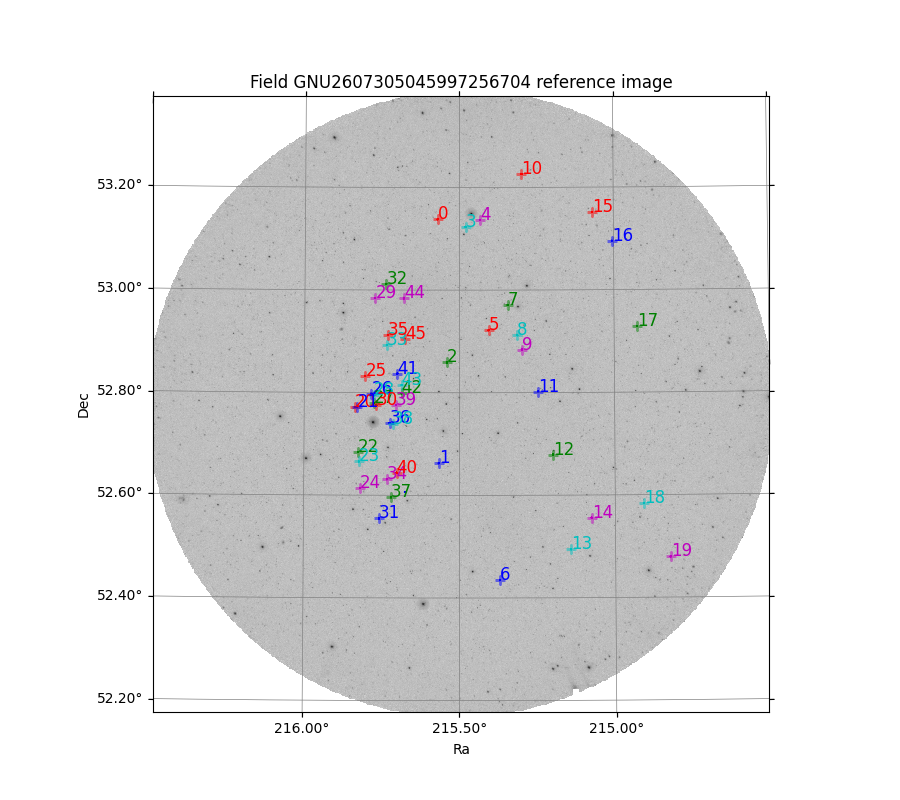

In [5]:
def plot_sky_field(rg_fd_id):
    if rg_fd_id not in rg.tt_fields["rg_fd_id"]:
        print("source ID does not exist") 
        return
    fig_skymap = plt.figure("Sky map",figsize=(9, 8), clear=True) #, constrained_layout=True
    fd = rg.get_field(rg_fd_id=rg_fd_id, load_method="FITS", add_field=True)
    ax, wcs = vvis.plot_field_sky_map(fd, img_idx=-1, sky_region = fd.get_sky_region(),fig=fig_skymap) # 
    ax, tt_src_shown = vvis.plot_sky_sources(rg.tt_sources,tt_det=rg.tt_detections, sky_region_wcs = (fd.get_sky_region(),wcs),only_selected=only_sel_srcs) # 
    plt.show()
    display(tt_src_shown) #[show_map_pars]
widgets.interactive( plot_sky_field, rg_fd_id=(rg.tt_fields["rg_fd_id"].min(),rg.tt_fields["rg_fd_id"].max()))